# <h1 align="center"><font color = #0081be>Lighthouse | Cientista de Dados | Indicium 🌎🚀</font></h1>

## <a><font color = #0081be>**Objetivos**</font></a>
A empresa Adventure Works (AW) é uma indústria de bicicletas com mais de 500 produtos distintos, 20.000 clientes e 31.000 pedidos. Nesse desafio, será realizada uma previsão de demanda, a fim, de ajustar a distribuição de produtos e ter uma melhor estimativa sobre a necessidade de compra de matéria prima.

> <a><font color = #0081be>**1.**</font></a> A fim de ajustar a distribuição de produtos e ter uma melhor estimativa sobre a necessidade de compra de matéria prima, faça uma previsão sobre a demanda dos próximos 3 meses de cada produto em cada loja. Além disso, aponte se há ou não a presença de sazonalidade em algum produto de sua escolha.

>  <a><font color = #0081be>**2.**</font></a> Seria possível resolver este problema através de uma abordagem utilizando modelos de regressão? Se sim, qual demonstra melhor resultado? Justifique utilizando métricas de avaliação.
   
> <a><font color = #0081be>**3.**</font></a> Os novos centros de distribuição passaram a ser divididos em províncias nos EUA e em países no resto do mundo. Qual desses grupos apresentou mais crescimento em demanda nos três meses previstos no item 1?
   
> <a><font color = #0081be>**4.**</font></a> Um novo fornecedor de luvas, que agora engloba toda a produção mundial, precisa ter uma estimativa de quantos zíperes precisa pedir para os próximos 3 meses. Levando em consideração que são necessários 2 zíperes por par, quantos seriam necessários?

## Instalações e importações das bibliotecas

In [1]:
!pip install statsforecast
!pip install hierarchicalforecast

In [2]:
!pip install unidecode

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from unidecode import unidecode
import xgboost as xgb

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose, DecomposeResult
from statsmodels.formula.api import ols

from hierarchicalforecast.utils import aggregate
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.methods import BottomUp, TopDown, MiddleOut

from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoETS, Naive, SeasonalNaive, HoltWinters

from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Carregamento dos dados

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
df = pd.read_csv('/content/drive/MyDrive/Desafio Adventure Works (AW)/3. DS/fct_sales_ds.csv', sep=',')

## Informações sobre o DataFrame

In [6]:
df.head()

,fct_sales_sk,sales_order_id,customer_fk,location_fk,credit_card_fk,reason_fk,product_fk,order_date,ship_date,status_sales,...,Price,Manufacturer,Quality,Promotion,Review,Other,Television,product_name,product_subcategory_name,product_category_name
0,00130421b800749324a8ae1bf05ee977,49735,77bd061c0e645ca42b087a6d0d06c019,cb99590f7cf124e88bdd3a40b3b1c8bb,NaN,NaN,4ea06fbc83cdd0a06020c35d50e1e89a,2013-02-16,2013-02-23,Enviado,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Road-650 Black, 52",Bicicletas de estrada,Bicicletas
1,00211762db188988992f94c8473bc7bd,51825,cb99590f7cf124e88bdd3a40b3b1c8bb,08c5433a60135c32e34f46a71175850c,30c58a19dde41f4ecbe4fa148968a31f,NaN,a4300b002bcfb71f291dac175d52df94,2013-06-30,2013-07-07,Enviado,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ML Mountain Seat/Saddle,Selas,Componentes
2,00cf839a2b8c68f28e810190863ba20e,53612,3dc2c2f6a6a75cba6bc726b4545e788c,9cf81d8026a9018052c429cc4e56739b,ff096d0e005a8c794b6c1da7c0fd662e,NaN,a3d68b461bd9d3533ee1dd3ce4628ed4,2013-07-31,2013-08-07,Enviado,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ML Crankset,Pedaleiras,Componentes
3,0114f115dae71d2b660dfbba918bf3c3,58951,407c81ae411f5e0a5c4a5b62c0ca9770,7f1171a78ce0780a2142a6eb7bc4f3c8,4afd521d77158e02aed37e2274b90c9c,NaN,d79aac075930c83c2f1e369a511148fe,2013-10-30,2013-11-06,Enviado,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Mountain-400-W Silver, 38",Bicicletas de montanha,Bicicletas
4,025d67c74c8a394e74accb78a36a537c,53586,a1e4a9d047858b87c17707c0c4e91657,c667d53acd899a97a85de0c201ba99be,3ecd2cd951c997ec03d1e428c7f15687,NaN,3df1d4b96d8976ff5986393e8767f5b2,2013-07-31,2013-08-07,Enviado,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ML Road Pedal,Pedais,Componentes


In [7]:
df.shape

(16957, 44)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16957 entries, 0 to 16956
Data columns (total 44 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   fct_sales_sk              16957 non-null  object 
 1   sales_order_id            16957 non-null  int64  
 2   customer_fk               16957 non-null  object 
 3   location_fk               16957 non-null  object 
 4   credit_card_fk            16768 non-null  object 
 5   reason_fk                 2303 non-null   object 
 6   product_fk                16957 non-null  object 
 7   order_date                16957 non-null  object 
 8   ship_date                 16957 non-null  object 
 9   status_sales              16957 non-null  object 
 10  onlineorderflag           16957 non-null  bool   
 11  subtotal                  16957 non-null  float64
 12  taxamt                    16957 non-null  float64
 13  freight                   16957 non-null  float64
 14  totald

**Informações estatísticas para variáveis numéricas**

In [9]:
df.describe()

,sales_order_id,subtotal,taxamt,freight,totaldue,orderqty,unitprice,unitpricediscount,amount_paid_product,standardcost,...,safetystocklevel,reorderpoint,daystomanufacture,Price,Manufacturer,Quality,Promotion,Review,Other,Television
count,16957.000000,16957.000000,16957.000000,16957.000000,16957.000000,16957.000000,16957.000000,16957.000000,16957.000000,16957.000000,...,16957.000000,16957.000000,16957.000000,2303.000000,2303.000000,2303.0,2303.000000,2303.000000,2303.000000,2303.0
mean,54719.795424,34601.273883,3392.907782,1060.283688,39054.465353,3.448900,448.152268,0.013752,883.833389,358.168614,...,265.835938,199.376953,1.591555,0.571863,0.007816,0.0,0.326531,0.188016,0.038645,0.0
std,8308.522412,30926.065980,3061.289825,956.653066,34930.052117,4.008917,665.360028,0.053647,1732.021484,506.104465,...,225.602231,169.201674,1.541536,0.494916,0.088080,0.0,0.469046,0.390810,0.192790,0.0
min,43659.000000,1.374000,0.109900,0.034400,1.518300,1.000000,1.374000,0.000000,1.374000,0.856500,...,4.000000,3.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
25%,48036.000000,3374.990000,271.999200,84.999800,3729.364000,1.000000,35.994000,0.000000,83.958000,24.745900,...,4.000000,3.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
50%,51739.000000,31643.602400,3097.907600,968.096100,35854.324100,2.000000,125.415000,0.000000,330.462000,77.917600,...,100.000000,75.000000,1.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
75%,59064.000000,51324.194500,5049.921800,1578.100600,57788.839500,4.000000,744.272700,0.000000,858.900000,486.706600,...,500.000000,375.000000,4.000000,1.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.0
max,75123.000000,163930.394300,17948.518600,5608.912100,187487.825000,44.000000,3399.990000,0.400000,30990.310000,2171.294200,...,500.000000,375.000000,4.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,0.0


**Informações estatísticas para as variáveis categóricas**

In [10]:
df.describe(include='object').T

,count,unique,top,freq
fct_sales_sk,16957,16957,00130421b800749324a8ae1bf05ee977,1
customer_fk,16957,3826,ff23707fd0625ccdfb4f42ddbaf1a649,179
location_fk,16957,3826,15de21c670ae7c3f6f3f1f37029303c9,179
credit_card_fk,16768,3674,b31f0c758bb498b5d56b5fea80f313a7,179
reason_fk,2303,2280,8962b25e779a30ecd4c5ed79e7b8efbd,2
product_fk,16957,199,67d16d00201083a2b118dd5128dd6f59,510
order_date,16957,984,2013-07-31,1249
ship_date,16957,984,2013-08-07,1249
status_sales,16957,1,Enviado,16957
customer_person_type,16957,2,Contato da loja,13247


## Tratamento de Valores Nulos

In [11]:
df.isnull().sum()

fct_sales_sk                    0
sales_order_id                  0
customer_fk                     0
location_fk                     0
credit_card_fk                189
reason_fk                   14654
product_fk                      0
order_date                      0
ship_date                       0
status_sales                    0
onlineorderflag                 0
subtotal                        0
taxamt                          0
freight                         0
totaldue                        0
orderqty                        0
unitprice                       0
unitpricediscount               0
amount_paid_product             0
standardcost                    0
listprice                       0
makeflag                        0
finishedgoodsflag               0
safetystocklevel                0
reorderpoint                    0
daystomanufacture               0
customer_person_type            0
name_store                   3710
city                            0
postalcode    

**Excluindo as *features* dos identificadores únicos**

In [12]:
df = df.drop('fct_sales_sk', axis=1)
df = df.drop('sales_order_id', axis=1)
df = df.drop('customer_fk', axis=1)
df = df.drop('location_fk', axis=1)
df = df.drop('credit_card_fk', axis=1)
df = df.drop('reason_fk', axis=1)
df = df.drop('product_fk', axis=1)
df = df.drop('status_sales', axis=1)
df = df.drop('cardtype', axis=1)
df = df.drop('ship_date', axis=1)

Para o tratamento dos dados Missing (NaN) iremos considerar que os valores ausentes das seguintes *features* são representados por 0.

In [13]:
df['Price'] = df['Price'].replace(np.nan, 0)
df['Manufacturer'] = df['Manufacturer'].replace(np.nan, 0)
df['Quality'] = df['Quality'].replace(np.nan, 0)
df['Promotion'] = df['Promotion'].replace(np.nan, 0)
df['Review'] = df['Review'].replace(np.nan, 0)
df['Other'] = df['Other'].replace(np.nan, 0)
df['Television'] = df['Television'].replace(np.nan, 0)

Os valores ausentes para a loja são representados por uma compra de um cliente individual

In [14]:
df['name_store'] = df['name_store'].replace(np.nan, 'Cliente individual')

## Pré-Processamento dos Dados

In [15]:
df['order_date'] = pd.to_datetime(df['order_date'])
df["month"] = pd.to_datetime(df["order_date"]).dt.to_period('M').dt.to_timestamp()

In [16]:
df['name_store'] = df['name_store'].str.replace('/', ' ')
df['product_name'] = df['product_name'].str.replace('/', ' ')
df['product_name'] = df['product_name'].str.replace('-', ' ')
df['country_region_name'] = df['country_region_name'].apply(lambda x: unidecode(str(x)))
df['product_subcategory_name'] = df['product_subcategory_name'].apply(lambda x: unidecode(str(x)))

## Análise Exploratória de Dados (EDA)

In [17]:
def plot_annotate(ax, title):
    """ Adicionar anotações nos gráficos.

    Args:
        ax: Objeto do tipo Axes do Matplotlib
        title (string): Título do gráfico
    Returns:
        None
    """

    for rect in ax.patches:
        ax.annotate(rect.get_height(),
                (rect.get_x() + rect.get_width()/2, rect.get_height()),
                ha='center', va='baseline', fontsize=8, color=neutral_500,
                xytext=(0, 1), textcoords="offset points")
    ax.set_title(title)


# Cores
cerulean="#0081be"
web_orange="#f7a600"
port_gore="#1a2144"
chambray="#333b8f"
sandal="#9c8b64"
curious_blue="#13a0db"
cornflower="#88bce7"
abbey="#1b1d1e"
neutral_500="#878b97"

In [18]:
monthly_sales = (
    df
    .groupby("month")["orderqty"].sum()
    .reset_index()
)

monthly_sales.head()

,month,orderqty
0,2011-05-01,79
1,2011-06-01,31
2,2011-07-01,325
3,2011-08-01,392
4,2011-09-01,31


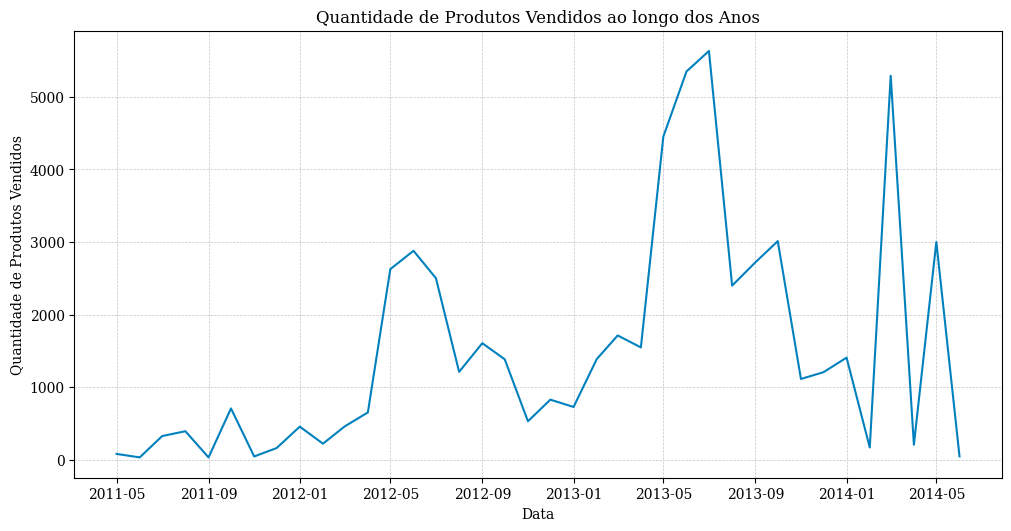

In [19]:
fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = monthly_sales.sort_values('month', ascending=True)

xs = df_sorted['month']
ys = df_sorted['orderqty']

plt.plot(xs, ys, color=cerulean)

plt.title('Quantidade de Produtos Vendidos ao longo dos Anos')
plt.xlabel('Data')
plt.ylabel('Quantidade de Produtos Vendidos')

plt.grid(True, linestyle='--', linewidth=0.5, color=neutral_500, alpha=0.5)

plt.show()

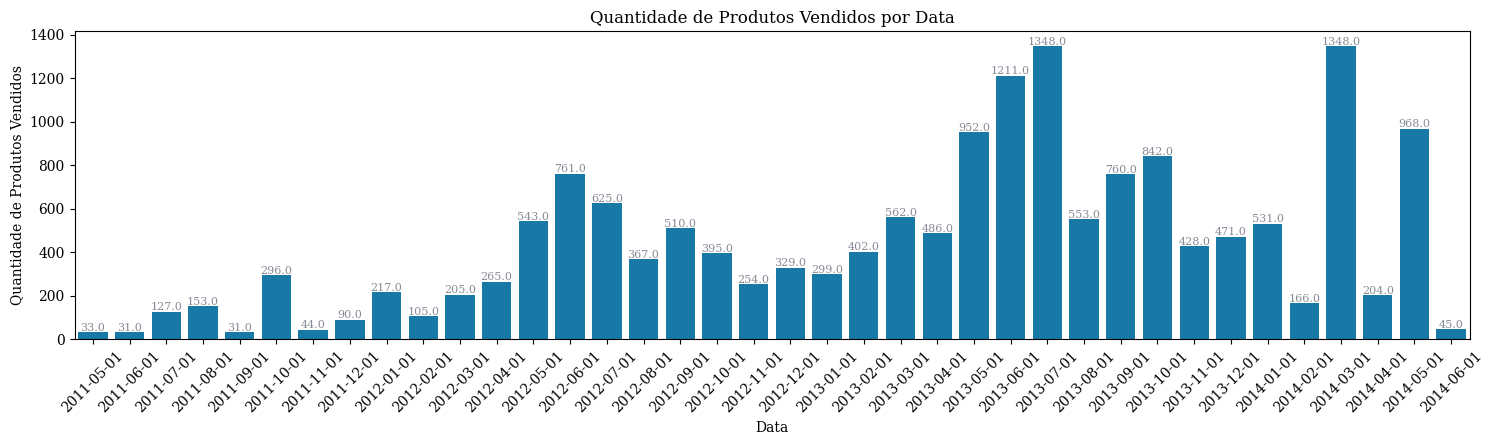

In [20]:
df['month'] = pd.to_datetime(df['month'])
df_sorted = df.sort_values('month')

fig, axs = plt.subplots(figsize=(18, 4))
ax = sns.countplot(x='month', data=df_sorted, color=cerulean)
plt.xticks(rotation=45)

plt.xlabel('Data')
plt.ylabel('Quantidade de Produtos Vendidos')
plot_annotate(ax, 'Quantidade de Produtos Vendidos por Data')
plt.show()

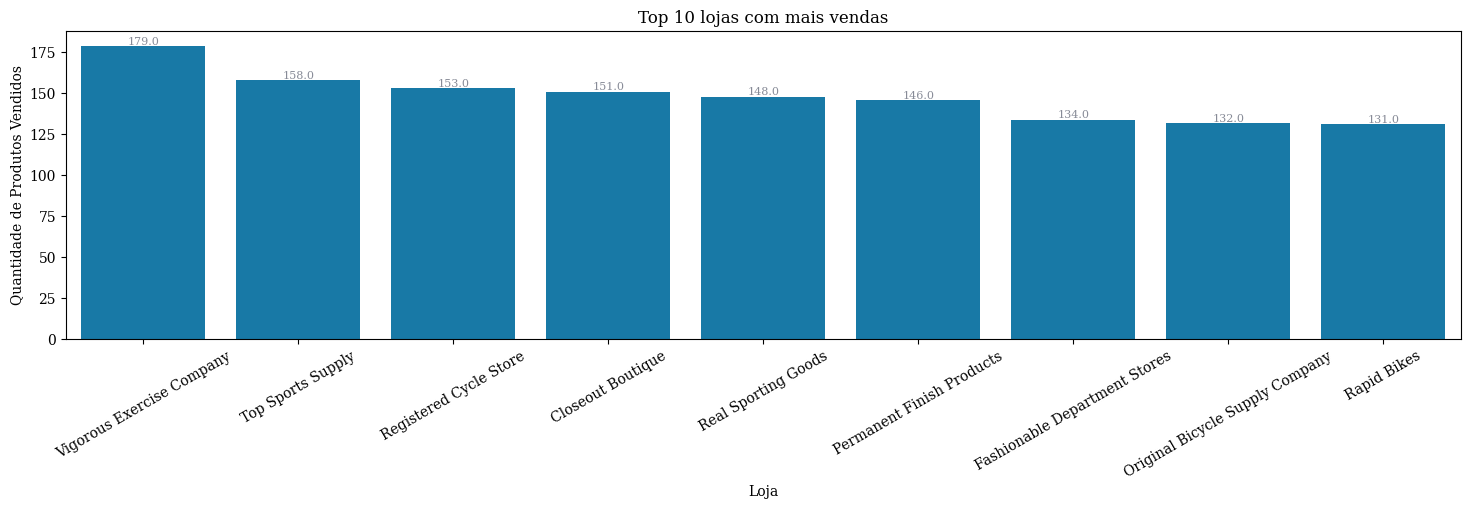

In [21]:
top_stores = df['name_store'].value_counts().nlargest(10).index
top_stores = top_stores[1:]
df_top_stores = df[df['name_store'].isin(top_stores)]
df_top_stores['name_store'] = pd.Categorical(df_top_stores['name_store'], categories=top_stores, ordered=True)


fig, axs = plt.subplots(figsize=(18, 4))
ax = sns.countplot(x='name_store', data=df_top_stores, color=cerulean)
plt.xticks(rotation=30)
plot_annotate(ax, 'Top 10 lojas com mais vendas')
plt.xlabel('Loja')
plt.ylabel('Quantidade de Produtos Vendidos')
plt.show()


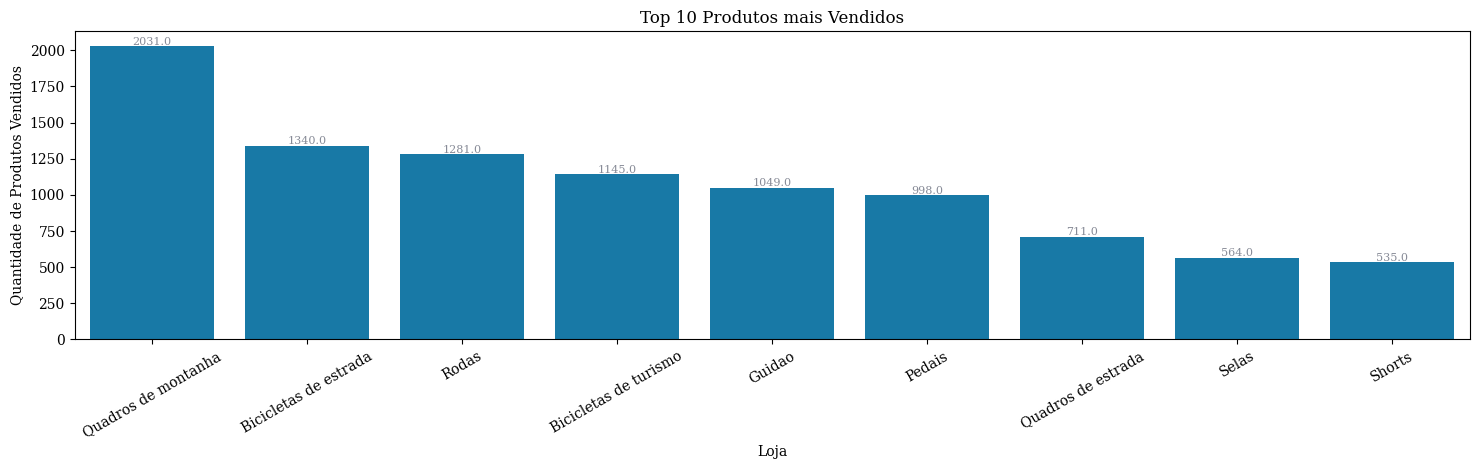

In [22]:
top_stores = df['product_subcategory_name'].value_counts().nlargest(10).index
top_stores = top_stores[1:]
df_top_stores = df[df['product_subcategory_name'].isin(top_stores)]
df_top_stores['product_subcategory_name'] = pd.Categorical(df_top_stores['product_subcategory_name'], categories=top_stores, ordered=True)


fig, axs = plt.subplots(figsize=(18, 4))
ax = sns.countplot(x='product_subcategory_name', data=df_top_stores, color=cerulean)
plt.xticks(rotation=30)
plot_annotate(ax, 'Top 10 Produtos mais Vendidos')
plt.xlabel('Loja')
plt.ylabel('Quantidade de Produtos Vendidos')
plt.show()


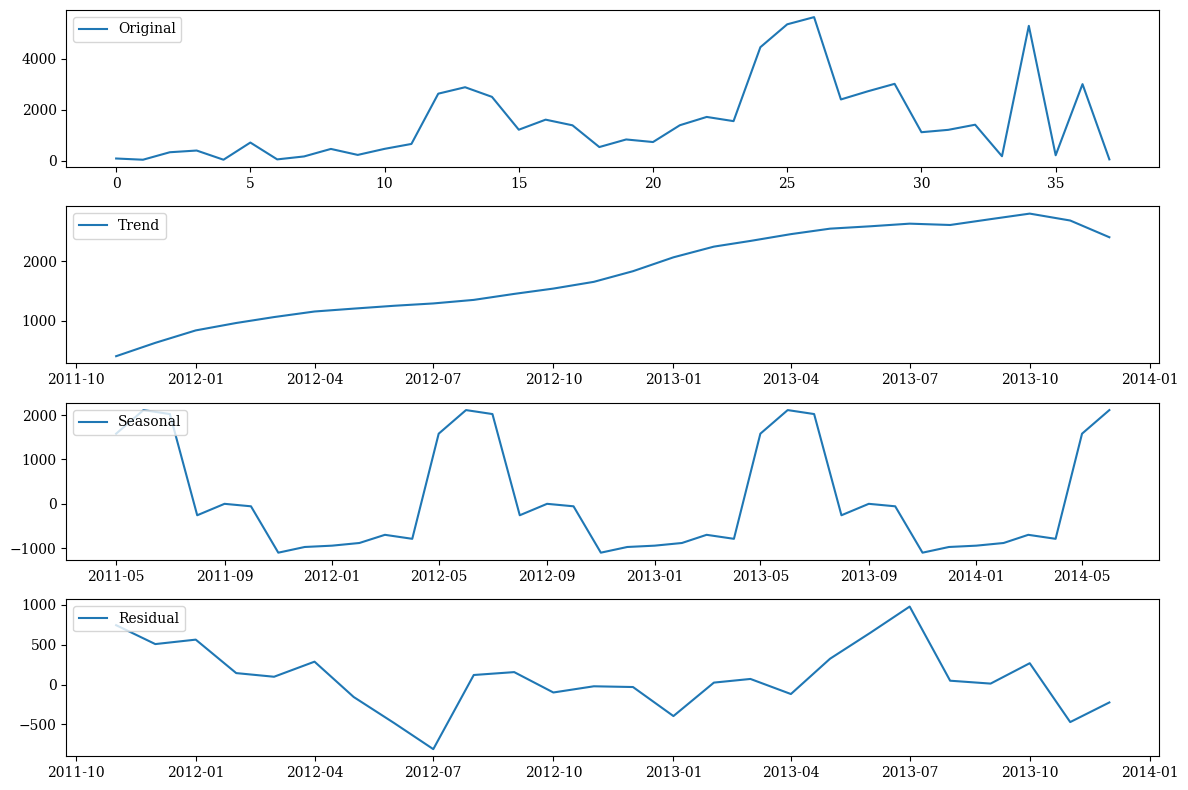

In [23]:
result = seasonal_decompose(monthly_sales.set_index('month')["orderqty"], model='additive', period=12)

def seasonal_decomposition_plots(data: pd.DataFrame, seasonal_decomposition: DecomposeResult):
    plt.figure(figsize=(12, 8))
    plt.subplot(4, 1, 1)
    plt.plot(data['orderqty'], label='Original')
    plt.legend(loc='upper left')

    plt.subplot(4, 1, 2)
    plt.plot(seasonal_decomposition.trend, label='Trend')
    plt.legend(loc='upper left')

    plt.subplot(4, 1, 3)
    plt.plot(seasonal_decomposition.seasonal, label='Seasonal')
    plt.legend(loc='upper left')

    plt.subplot(4, 1, 4)
    plt.plot(seasonal_decomposition.resid, label='Residual')
    plt.legend(loc='upper left')

    plt.tight_layout()

    return plt.show()

seasonal_decomposition_plots(data=monthly_sales, seasonal_decomposition=result)

## Séries Hierárquicas






<blockquote class="callout callout_default" theme="📌">
  <h4>📌 <font color = #0081be><b>1.</b></font> A fim de ajustar a distribuição de produtos e ter uma melhor estimativa sobre a necessidade de compra de matéria prima, faça uma previsão sobre a demanda dos próximos 3 meses de cada produto em cada loja. Além disso, aponte se há ou não a presença de sazonalidade em algum produto de sua escolha.</h4>

  * Para analisar a distribuição de produtos, foi empregado o modelo ***AutoARIMA*** para prever a demanda dos próximos três meses para cada produto em cada região e loja.
  * Além disso, foi investigado a sazonalidade específica dos produtos do tipo 'Bicicletas'.
</blockquote>



In [24]:
hts = (
    df
    .groupby([
        'month','product_subcategory_name', 'country_region_name', 'name_store'])["orderqty"].sum()
    .reset_index()
)
hts.head()

,month,product_subcategory_name,country_region_name,name_store,orderqty
0,2011-05-01,Bicicletas de estrada,Canada,"Health Spa, Limited",2
1,2011-05-01,Bicicletas de estrada,Canada,Retail Mall,2
2,2011-05-01,Bicicletas de estrada,Estados Unidos,Basic Bike Company,1
3,2011-05-01,Bicicletas de estrada,Estados Unidos,Bike Rims Company,1
4,2011-05-01,Bicicletas de estrada,Estados Unidos,Cliente individual,1


In [25]:
hierarchies = [
    ['product_subcategory_name'],
    ['product_subcategory_name', 'country_region_name'],
    ['product_subcategory_name', 'country_region_name', 'name_store'],
]

In [26]:
hts = hts.rename(columns={"month": "ds", "orderqty": "y"})

In [27]:
Y_df, S_df, tags = aggregate(hts, hierarchies)
Y_df = Y_df.reset_index()

**Divisão dos dados em treinamento e teste**

In [28]:
# Selecionando os últimos 3 meses para teste
test_agg = Y_df.groupby('unique_id').tail(3)
train_agg = Y_df.drop(test_agg.index)

test_agg = test_agg.set_index('unique_id')
train_agg = train_agg.set_index('unique_id')

### Treinamento do modelo

In [29]:
fcst = StatsForecast(
    df=train_agg,
    models=[AutoARIMA(season_length=3)],
    freq='MS',
    n_jobs=-1
  )

In [30]:
Y_hat_df = fcst.forecast(h=3, fitted=True)

In [31]:
p_fitted = fcst.forecast_fitted_values()

In [32]:
xmat = pd.merge(left=test_agg.reset_index(), right=Y_hat_df.reset_index(), on=['unique_id', 'ds'])
xmat2 = xmat.copy()

**Previsão sobre a demanda dos próximos 3 meses de cada produto/país/loja**

In [33]:
xmat['ds'] = pd.to_datetime(xmat['ds'])
xmat_filtrado = xmat[xmat['ds'] >= '2014-03-01']
xmat_filtrado = xmat_filtrado.sort_values(by='ds', ascending=True)

xmat_filtrado.columns = ['Produtos', 'Data', 'Real', 'Previsão']

xmat_filtrado.head(20)

,Produtos,Data,Real,Previsão
255,Guidao/Franca,2014-03-01,22,4.076487
328,Quadros de montanha/Estados Unidos,2014-03-01,304,110.785065
330,Quadros de montanha/Franca,2014-03-01,45,24.056526
332,Quadros de montanha/Reino Unido,2014-03-01,21,2.658646
349,Selas/Australia,2014-03-01,3,2.000000
352,Selas/Estados Unidos,2014-03-01,105,18.000000
355,Selas/Reino Unido,2014-03-01,2,2.000000
359,Shorts/Estados Unidos,2014-03-01,355,48.844585
363,Suportes para bicicletas/Alemanha,2014-03-01,5,1.000000
165,Colchetes Inferiores/Estados Unidos,2014-03-01,21,0.000000


### Métricas

**Métricas MSE (Erro Quadrático Médio), RMSE (Raiz do Erro Quadrático Médio) e MSA (Erro Absoluto Médio) - AutoArima**

In [34]:
def my_rmse(x,y):
    return(np.round( np.sqrt(mse(x.values,y.values)) ,4))

def my_mse(x, y):
    return np.round(mse(x.values, y.values), 4)

def my_mae(x, y):
    return np.nanmean(abs(x.values -  y.values))

def creating_results(p_rec_):
  results = []
  for k in tags.keys():
      k_rmse = my_rmse(p_rec_.loc[p_rec_['unique_id'].isin(tags[k]), 'y'], p_rec_.loc[p_rec_['unique_id'].isin(tags[k]), 'pred'])
      k_mse = my_mse(p_rec_.loc[p_rec_['unique_id'].isin(tags[k]), 'y'], p_rec_.loc[p_rec_['unique_id'].isin(tags[k]), 'pred'])
      k_mae = my_mae(p_rec_.loc[p_rec_['unique_id'].isin(tags[k]), 'y'], p_rec_.loc[p_rec_['unique_id'].isin(tags[k]), 'pred'])

      results.append({'Category': k, 'RMSE': k_rmse, 'MSE': k_mse, 'MAE': k_mae})
      results_df = pd.DataFrame(results)

  return results_df

In [35]:
xmat2.columns = ['unique_id', 'ds', 'y', 'pred']
result_xmat2 = creating_results(xmat2)
result_xmat2.head()

,Category,RMSE,MSE,MAE
0,product_subcategory_name,131.2021,17214.0035,85.782920
1,product_subcategory_name/country_region_name,41.8469,1751.1620,20.754588
2,product_subcategory_name/country_region_name/n...,8.7375,76.3447,5.461853


In [36]:
k_rmse = my_rmse(xmat2['y'], xmat2['pred'])
k_mse = my_mse(xmat2['y'], xmat2['pred'])
k_mae = my_mae(xmat2['y'], xmat2['pred'])

results_arima = {'RMSE': [k_rmse], 'MSE': [k_mse], 'MAE': [k_mae]}
results_df_arima = pd.DataFrame(results_arima)
results_df_arima

,RMSE,MSE,MAE
0,39.6053,1568.5827,14.504219


### Sazonalidade

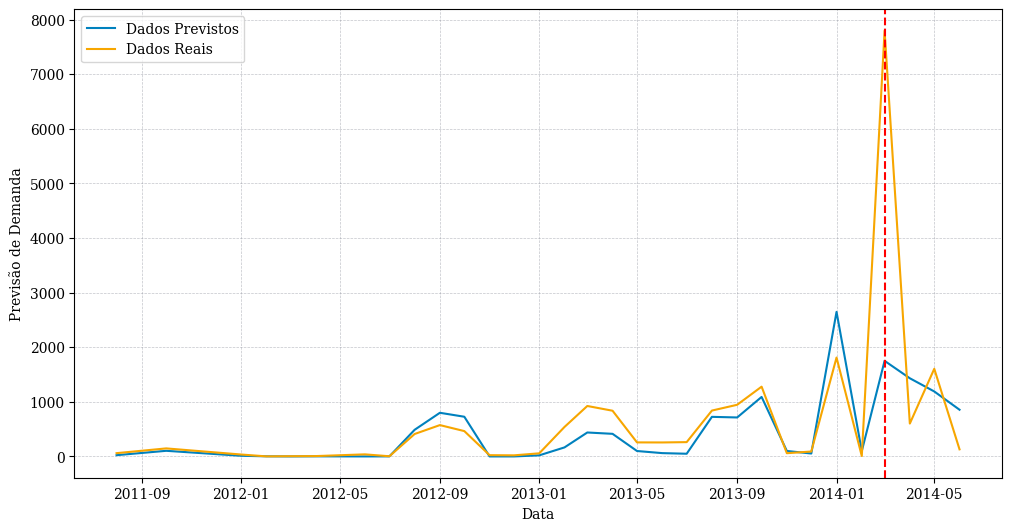

In [37]:
monthly_sales_pred = (
    xmat2
    .groupby("ds")["pred"].sum()
    .reset_index()
)

monthly_sales_y = (
    xmat2
    .groupby("ds")["y"].sum()
    .reset_index()
)

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')

# Dados Previstos
df_sorted_pred = monthly_sales_pred.sort_values('ds', ascending=True)
xs_pred = df_sorted_pred['ds']
ys_pred = df_sorted_pred['pred']
plt.plot(xs_pred, ys_pred, color=cerulean, label='Dados Previstos')

# Dados Reais
df_sorted_real = monthly_sales_y.sort_values('ds', ascending=True)
xs_real = df_sorted_real['ds']
ys_real = df_sorted_real['y']
plt.plot(xs_real, ys_real, color=web_orange, label='Dados Reais')

# plt.axvline(x='2014-03-01', color='red', linestyle='--')
date_to_plot = pd.to_datetime('2014-03-01')
plt.axvline(x=date_to_plot, color='red', linestyle='--')

plt.xlabel('Data')
plt.ylabel('Previsão de Demanda')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, color=neutral_500, alpha=0.5)

plt.show()

**Analisando as vendas do produto 'Bicicletas'**

In [38]:
Y_hat_df_filtered = xmat2[xmat2['unique_id'].str.contains("Bicicletas")]
Y_hat_df_filtered

,unique_id,ds,y,pred
3,Bicicletas de estrada,2014-02-01,1,28.520136
4,Bicicletas de estrada,2014-03-01,53,26.884335
5,Bicicletas de montanha,2014-03-01,438,111.846436
6,Bicicletas de montanha,2014-04-01,54,111.846436
7,Bicicletas de montanha,2014-05-01,260,111.846436
...,...,...,...,...
514,Bicicletas de turismo/Franca/Cliente individual,2014-04-01,9,9.000000
515,Bicicletas de turismo/Franca/Cliente individual,2014-05-01,8,5.000000
516,Bicicletas de turismo/Reino Unido/Cliente indi...,2014-03-01,9,6.583311
517,Bicicletas de turismo/Reino Unido/Cliente indi...,2014-04-01,8,6.583310


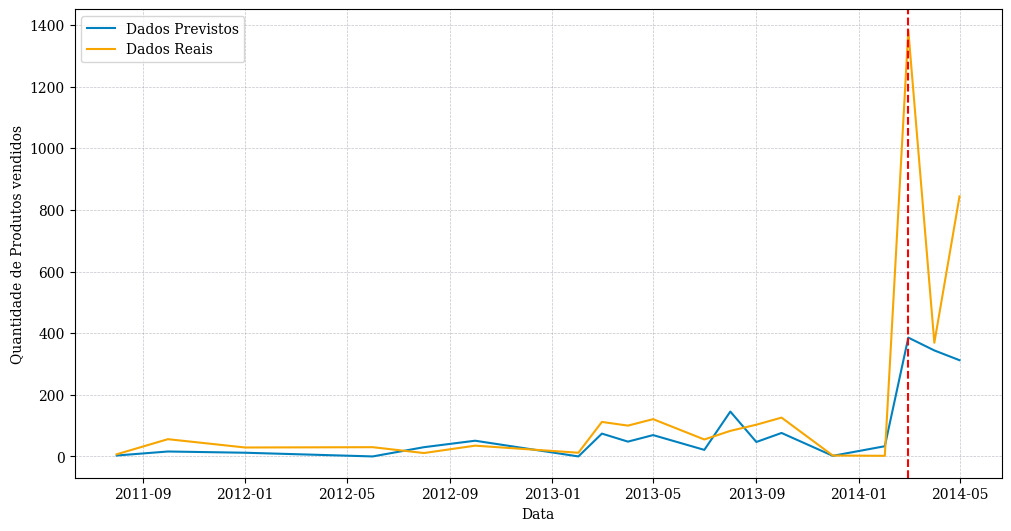

In [39]:
monthly_sales_pred = (
    Y_hat_df_filtered
    .groupby("ds")["pred"].sum()
    .reset_index()
)

monthly_sales_y = (
    Y_hat_df_filtered
    .groupby("ds")["y"].sum()
    .reset_index()
)

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')

df_sorted_pred = monthly_sales_pred.sort_values('ds', ascending=True)
df_sorted_y = monthly_sales_y.sort_values('ds', ascending=True)

xs_pred = df_sorted_pred['ds']
ys_pred = df_sorted_pred['pred']

xs_y = df_sorted_y['ds']
ys_y = df_sorted_y['y']

plt.plot(xs_pred, ys_pred, color=cerulean, label='Dados Previstos')
plt.plot(xs_y, ys_y, color=web_orange, label='Dados Reais')

date_to_plot = pd.to_datetime('2014-03-01')
plt.axvline(x=date_to_plot, color='red', linestyle='--')

plt.xlabel('Data')
plt.ylabel('Quantidade de Produtos vendidos')

plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, color=neutral_500, alpha=0.5)

plt.show()

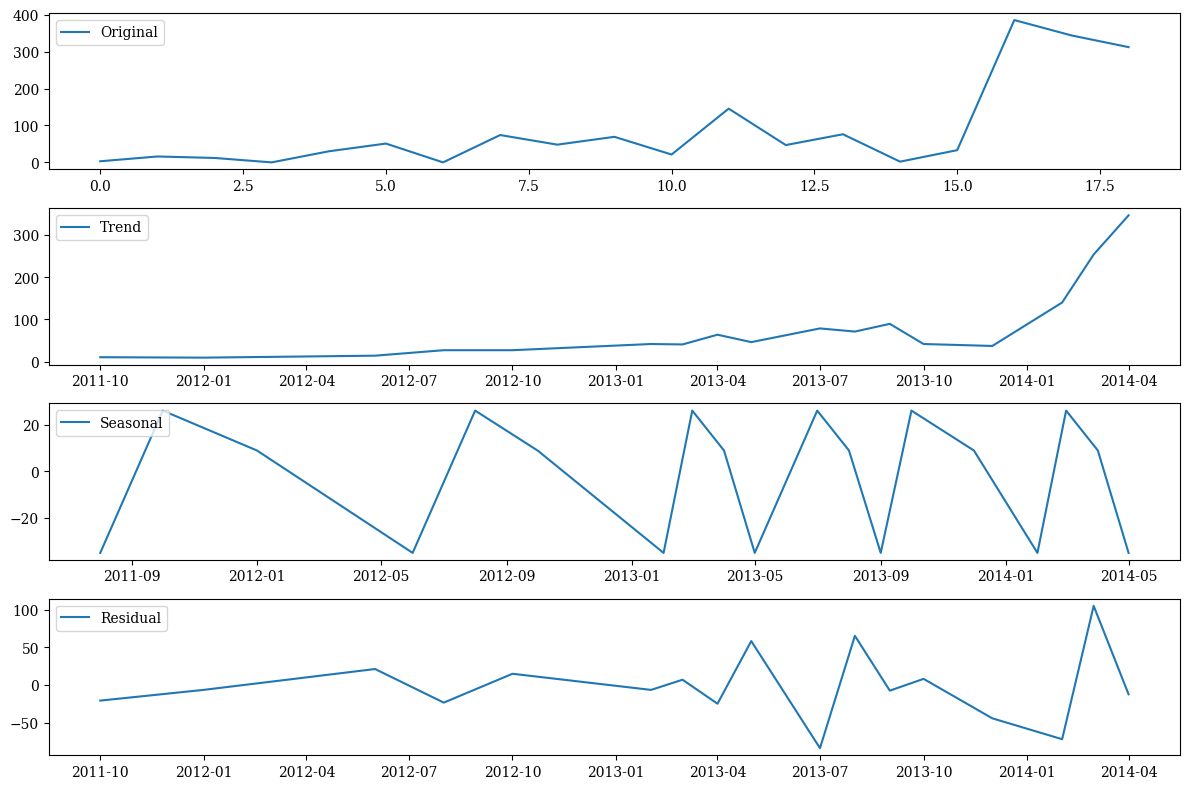

In [40]:
monthly_sales = (
    Y_hat_df_filtered
    .groupby("ds")["pred"].sum()
    .reset_index()
)

result = seasonal_decompose(monthly_sales.set_index('ds')["pred"], model='additive', period=3)

def seasonal_decomposition_plots(data: pd.DataFrame, seasonal_decomposition: DecomposeResult):

    # Plot the original time series, trend, seasonality, and residual
    plt.figure(figsize=(12, 8))
    plt.subplot(4, 1, 1)
    plt.plot(data['pred'], label='Original')
    plt.legend(loc='upper left')

    plt.subplot(4, 1, 2)
    plt.plot(seasonal_decomposition.trend, label='Trend')
    plt.legend(loc='upper left')

    plt.subplot(4, 1, 3)
    plt.plot(seasonal_decomposition.seasonal, label='Seasonal')
    plt.legend(loc='upper left')

    plt.subplot(4, 1, 4)
    plt.plot(seasonal_decomposition.resid, label='Residual')
    plt.legend(loc='upper left')

    plt.tight_layout()

    return plt.show()

seasonal_decomposition_plots(data=monthly_sales, seasonal_decomposition=result)

<blockquote class="callout callout_default" theme="✅">
  <p>✅ Durante a análise, foram abalisadas as métricas de desempenho, incluindo RMSE, MSE e MSA. Além disso, foi identificada a sazonalidade nos padrões de venda do produto 'Bicicletas'.</p>
</blockquote>

## Regressão com XGBoost Regressor

<blockquote class="callout callout_default" theme="📌">
  <h4>📌 <font color = #0081be><b>2.</b></font> Seria possível resolver este problema através de uma abordagem utilizando modelos de regressão? Se sim, qual demonstra melhor resultado? Justifique utilizando métricas de avaliação.</h4>

  * Será empregado o modelo ***XGBoost Regressor*** e será realizada a análise, avaliando métricas de desempenho essenciais, tais como o MSE (Erro Quadrático Médio), RMSE (Raiz do Erro Quadrático Médio) e MSA (Erro Absoluto Médio).
</blockquote>


**Preparação dos Dados**

In [59]:
df2 = df.copy()
df2.head()

,order_date,onlineorderflag,subtotal,taxamt,freight,totaldue,orderqty,unitprice,unitpricediscount,amount_paid_product,...,Manufacturer,Quality,Promotion,Review,Other,Television,product_name,product_subcategory_name,product_category_name,month
0,2013-02-16,True,782.9900,62.6392,19.5748,865.2040,1,782.990,0.0,782.990,...,0.0,0.0,0.0,0.0,0.0,0.0,"Road 650 Black, 52",Bicicletas de estrada,Bicicletas,2013-02-01
1,2013-06-30,False,55934.0580,5406.3906,1689.4971,63029.9457,10,23.484,0.0,234.840,...,0.0,0.0,0.0,0.0,0.0,0.0,ML Mountain Seat Saddle,Selas,Componentes,2013-06-01
2,2013-07-31,False,1669.0320,160.5107,50.1596,1879.7023,1,153.894,0.0,153.894,...,0.0,0.0,0.0,0.0,0.0,0.0,ML Crankset,Pedaleiras,Componentes,2013-07-01
3,2013-10-30,False,32797.2657,3129.8619,978.0819,36905.2095,3,461.694,0.0,1385.082,...,0.0,0.0,0.0,0.0,0.0,0.0,"Mountain 400 W Silver, 38",Bicicletas de montanha,Bicicletas,2013-10-01
4,2013-07-31,False,2760.4440,248.5478,77.6712,3086.6630,1,37.254,0.0,37.254,...,0.0,0.0,0.0,0.0,0.0,0.0,ML Road Pedal,Pedais,Componentes,2013-07-01


In [60]:
df2 = df2.drop('order_date', axis=1)
df2 = df2.drop('onlineorderflag', axis=1)
df2 = df2.drop('makeflag', axis=1)
df2 = df2.drop('finishedgoodsflag', axis=1)
df2 = df2.drop('daystomanufacture', axis=1)
df2 = df2.drop('customer_person_type', axis=1)
df2 = df2.drop('postalcode', axis=1)
df2 = df2.drop('state_province_name', axis=1)
df2 = df2.drop('territory_name', axis=1)
df2 = df2.drop('product_name', axis=1)
df2 = df2.drop('product_category_name', axis=1)
df2 = df2.drop('city', axis=1)

**Agrupamento dos dados**

In [61]:
hts = (
    df2
    .groupby([
        'month', 'product_subcategory_name',
        'country_region_name', 'name_store'])['subtotal', 'taxamt', 'freight',
                                              'totaldue', 'unitprice', 'unitpricediscount',
                                              'amount_paid_product', 'standardcost',
                                              'listprice', 'safetystocklevel', 'reorderpoint',
                                              'Price', 'Manufacturer', 'Quality', 'Promotion',
                                              'Review', 'Other',  'Television', 'orderqty'].sum().reset_index()
)

hts.head()

,month,product_subcategory_name,country_region_name,name_store,subtotal,taxamt,freight,totaldue,unitprice,unitpricediscount,...,safetystocklevel,reorderpoint,Price,Manufacturer,Quality,Promotion,Review,Other,Television,orderqty
0,2011-05-01,Bicicletas de estrada,Canada,"Health Spa, Limited",57665.0578,5550.3292,1734.4778,64949.8648,4293.9240,0.0,...,200,150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,2011-05-01,Bicicletas de estrada,Canada,Retail Mall,35944.1562,3461.7654,1081.8017,40487.7233,2146.9620,0.0,...,100,75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,2011-05-01,Bicicletas de estrada,Estados Unidos,Basic Bike Company,8128.7876,780.8136,244.0042,9153.6054,2146.9620,0.0,...,100,75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,2011-05-01,Bicicletas de estrada,Estados Unidos,Bike Rims Company,13787.5434,1323.0668,413.4584,15524.0686,2146.9620,0.0,...,100,75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,2011-05-01,Bicicletas de estrada,Estados Unidos,Cliente individual,699.0982,55.9279,17.4775,772.5036,699.0982,0.0,...,100,75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


**Criando uma coluna com as categorias agrupadas**

In [62]:
def concatenar_valores(row):
    return '/'.join(row)

hts['concat'] = hts[['product_subcategory_name', 'country_region_name', 'name_store']].apply(concatenar_valores, axis=1)
hts.head()

,month,product_subcategory_name,country_region_name,name_store,subtotal,taxamt,freight,totaldue,unitprice,unitpricediscount,...,reorderpoint,Price,Manufacturer,Quality,Promotion,Review,Other,Television,orderqty,concat
0,2011-05-01,Bicicletas de estrada,Canada,"Health Spa, Limited",57665.0578,5550.3292,1734.4778,64949.8648,4293.9240,0.0,...,150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,"Bicicletas de estrada/Canada/Health Spa, Limited"
1,2011-05-01,Bicicletas de estrada,Canada,Retail Mall,35944.1562,3461.7654,1081.8017,40487.7233,2146.9620,0.0,...,75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,Bicicletas de estrada/Canada/Retail Mall
2,2011-05-01,Bicicletas de estrada,Estados Unidos,Basic Bike Company,8128.7876,780.8136,244.0042,9153.6054,2146.9620,0.0,...,75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,Bicicletas de estrada/Estados Unidos/Basic Bik...
3,2011-05-01,Bicicletas de estrada,Estados Unidos,Bike Rims Company,13787.5434,1323.0668,413.4584,15524.0686,2146.9620,0.0,...,75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,Bicicletas de estrada/Estados Unidos/Bike Rims...
4,2011-05-01,Bicicletas de estrada,Estados Unidos,Cliente individual,699.0982,55.9279,17.4775,772.5036,699.0982,0.0,...,75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,Bicicletas de estrada/Estados Unidos/Cliente i...


In [63]:
hts = hts.set_index('month')
hts.index = pd.to_datetime(hts.index)

In [64]:
hts2 = hts.drop('concat', axis=1)
df_valores_concatenados = hts.loc[:, ['concat']]

In [65]:
# Codificação de rótulos para variáveis categóricas
label_encoder = LabelEncoder()
hts2['name_store'] = label_encoder.fit_transform(hts2['name_store'])
hts2['product_subcategory_name'] = label_encoder.fit_transform(hts2['product_subcategory_name'])
hts2['country_region_name'] = label_encoder.fit_transform(hts2['country_region_name'])

df_concat = hts2.copy()

**Divisão dos dados em treinamento e teste**

In [66]:
train = hts2.loc[hts2.index < '2014-03-01']
test = hts2.loc[hts2.index >= '2014-03-01']

features = ['subtotal', 'taxamt', 'freight', 'totaldue', 'unitprice', 'unitpricediscount',
            'amount_paid_product', 'standardcost', 'listprice', 'safetystocklevel',
            'reorderpoint', 'name_store', 'country_region_name', 'Price', 'Manufacturer',
            'Quality', 'Promotion',  'Review', 'Other', 'Television', 'product_subcategory_name']

target = 'orderqty'

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

### Treinamento do modelo

In [67]:
reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:9.39920	validation_1-rmse:8.68084
[100]	validation_0-rmse:4.94340	validation_1-rmse:4.55887
[200]	validation_0-rmse:3.46588	validation_1-rmse:3.44702
[300]	validation_0-rmse:2.85820	validation_1-rmse:3.07703
[400]	validation_0-rmse:2.52862	validation_1-rmse:2.78134
[500]	validation_0-rmse:2.33338	validation_1-rmse:2.57922
[600]	validation_0-rmse:2.20091	validation_1-rmse:2.43508
[700]	validation_0-rmse:2.08910	validation_1-rmse:2.32634
[800]	validation_0-rmse:1.98970	validation_1-rmse:2.24568
[900]	validation_0-rmse:1.89513	validation_1-rmse:2.15347
[999]	validation_0-rmse:1.82139	validation_1-rmse:2.08172


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

**Feature Importance**

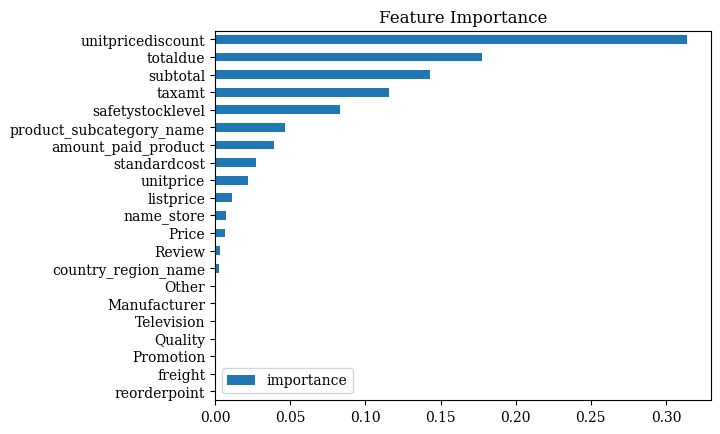

In [68]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])

fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

### Métricas

**Métricas MSE (Erro Quadrático Médio), RMSE (Raiz do Erro Quadrático Médio) e MSA (Erro Absoluto Médio) - AutoArima**

In [69]:
test['prediction'] = reg.predict(X_test)
hts2 = hts2.merge(test[['prediction']], how='left', left_index=True, right_index=True)

In [70]:
def my_rmse(x,y):
    return(np.round( np.sqrt(mse(x.values,y.values)) ,4))

def my_mse(x, y):
    return np.round(mse(x.values, y.values), 4)

def my_mae(x, y):
    return np.nanmean(abs(x.values -  y.values))

In [71]:
k_rmse = my_rmse(test['orderqty'], test['prediction'])
k_mse = my_mse(test['orderqty'], test['prediction'])
k_mae = my_mae(test['orderqty'], test['prediction'])

results_xgboost = {'RMSE': [k_rmse], 'MSE': [k_mse], 'MAE': [k_mae]}
results_df_xgboost = pd.DataFrame(results_xgboost)
results_df_xgboost

,RMSE,MSE,MAE
0,2.0817,4.3336,1.181628


In [72]:
df_resultado_metricas = pd.concat([results_df_arima, results_df_xgboost], ignore_index=True)
df_resultado_metricas = df_resultado_metricas.rename(index={0: 'AutoARIMA', 1: 'XGBoost'})

df_resultado_metricas.head()

,RMSE,MSE,MAE
AutoARIMA,39.6053,1568.5827,14.504219
XGBoost,2.0817,4.3336,1.181628


**Previsão sobre a demanda dos próximos 3 meses de cada produto/país/loja**

In [73]:
df_concat['produto/pais/loja'] = df_valores_concatenados['concat']
df_concat.tail(10)

,product_subcategory_name,country_region_name,name_store,subtotal,taxamt,freight,totaldue,unitprice,unitpricediscount,amount_paid_product,...,reorderpoint,Price,Manufacturer,Quality,Promotion,Review,Other,Television,orderqty,produto/pais/loja
month,,,,,,,,,,,,,,,,,,,,,
2014-06-01,0,3,73,727.16,58.1728,18.1790,803.5118,600.0,0.0,600.0,...,15,2.0,0.0,0.0,0.0,2.0,0.0,0.0,5,Bicicletarios/Estados Unidos/Cliente individual
2014-06-01,9,0,73,153.97,12.3176,3.8493,170.1369,127.0,0.0,127.0,...,6,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2,Coletes/Alemanha/Cliente individual
2014-06-01,9,1,73,528.39,42.2712,13.2099,583.8711,317.5,0.0,317.5,...,15,4.0,0.0,0.0,0.0,0.0,0.0,0.0,5,Coletes/Australia/Cliente individual
2014-06-01,9,2,73,675.87,54.0696,16.8969,746.8365,444.5,0.0,444.5,...,21,7.0,0.0,0.0,0.0,0.0,1.0,0.0,7,Coletes/Canada/Cliente individual
2014-06-01,9,3,73,787.87,63.0296,19.6969,870.5965,508.0,0.0,508.0,...,24,6.0,0.0,0.0,0.0,0.0,0.0,0.0,8,Coletes/Estados Unidos/Cliente individual
2014-06-01,9,4,73,100.09,8.0072,2.5023,110.5995,63.5,0.0,63.5,...,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,Coletes/Franca/Cliente individual
2014-06-01,9,5,73,285.66,22.8528,7.1416,315.6544,190.5,0.0,190.5,...,9,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3,Coletes/Reino Unido/Cliente individual
2014-06-01,32,1,73,480.99,38.4792,12.0248,531.4940,477.0,0.0,477.0,...,9,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3,Suportes para bicicletas/Australia/Cliente ind...
2014-06-01,32,2,73,383.95,30.7160,9.5988,424.2648,318.0,0.0,318.0,...,6,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2,Suportes para bicicletas/Canada/Cliente indivi...


In [74]:
df_concat  = df_concat.merge(test[['prediction']], how='left', left_index=True, right_index=True)
df_concat.tail(10)

,product_subcategory_name,country_region_name,name_store,subtotal,taxamt,freight,totaldue,unitprice,unitpricediscount,amount_paid_product,...,Price,Manufacturer,Quality,Promotion,Review,Other,Television,orderqty,produto/pais/loja,prediction
month,,,,,,,,,,,,,,,,,,,,,
2014-06-01,32,3,73,579.68,46.3744,14.4921,640.5465,477.0,0.0,477.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3,Suportes para bicicletas/Estados Unidos/Client...,4.552898
2014-06-01,32,3,73,579.68,46.3744,14.4921,640.5465,477.0,0.0,477.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3,Suportes para bicicletas/Estados Unidos/Client...,2.590522
2014-06-01,32,3,73,579.68,46.3744,14.4921,640.5465,477.0,0.0,477.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3,Suportes para bicicletas/Estados Unidos/Client...,4.149674
2014-06-01,32,3,73,579.68,46.3744,14.4921,640.5465,477.0,0.0,477.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3,Suportes para bicicletas/Estados Unidos/Client...,5.706373
2014-06-01,32,3,73,579.68,46.3744,14.4921,640.5465,477.0,0.0,477.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3,Suportes para bicicletas/Estados Unidos/Client...,6.626536
2014-06-01,32,3,73,579.68,46.3744,14.4921,640.5465,477.0,0.0,477.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3,Suportes para bicicletas/Estados Unidos/Client...,1.798635
2014-06-01,32,3,73,579.68,46.3744,14.4921,640.5465,477.0,0.0,477.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3,Suportes para bicicletas/Estados Unidos/Client...,2.653831
2014-06-01,32,3,73,579.68,46.3744,14.4921,640.5465,477.0,0.0,477.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3,Suportes para bicicletas/Estados Unidos/Client...,4.110799
2014-06-01,32,3,73,579.68,46.3744,14.4921,640.5465,477.0,0.0,477.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3,Suportes para bicicletas/Estados Unidos/Client...,3.409920


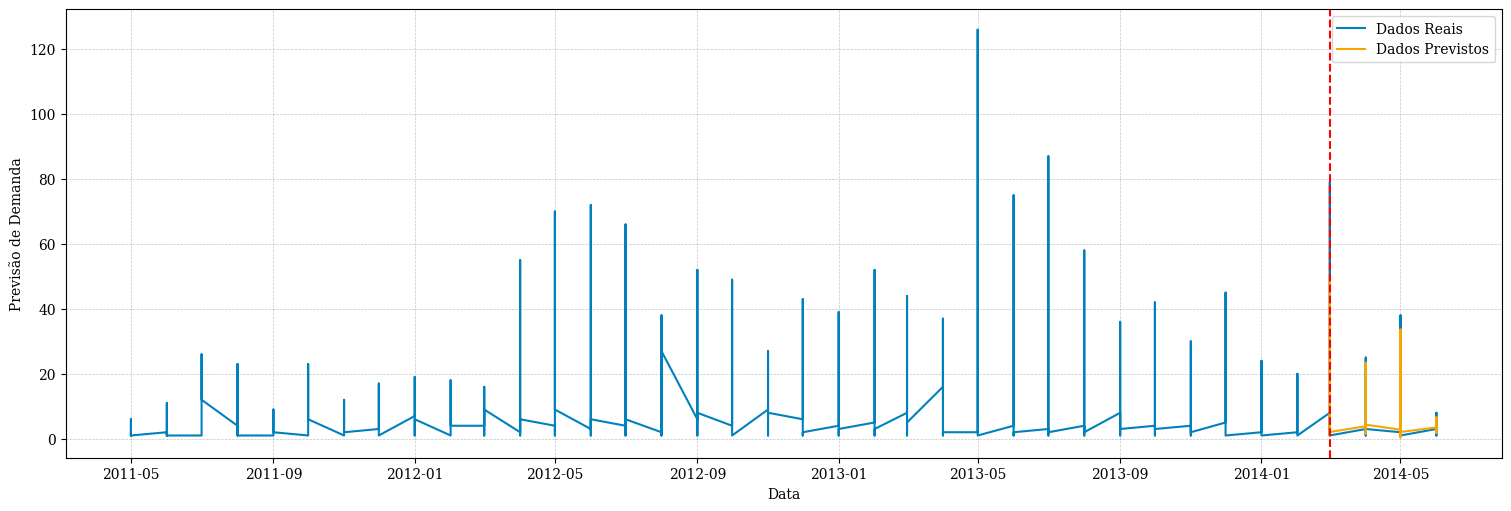

In [76]:
fig, ax = plt.subplots(figsize=(15, 5), layout='constrained')

# Dados Reais
plt.plot(df_concat[['orderqty']], color=cerulean, label='Dados Reais')

# Dados Previstos
plt.plot(df_concat['prediction'], color=web_orange, label='Dados Previstos')

date_to_plot = pd.to_datetime('2014-03-01')
plt.axvline(x=date_to_plot, color='red', linestyle='--')

plt.xlabel('Data')
plt.ylabel('Previsão de Demanda')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, color=neutral_500, alpha=0.5)

plt.show()

<blockquote class="callout callout_default" theme="✅">
  <p>✅ Durante a análise das métricas de desempenho  entre os modelos AutoARIMA e XGBoost, pode-se observar diferenças significativas em suas performances. O modelo para o XGBoost apresentou resultados consideravelmente menores do que os do AutoARIMAm indicando uma melhor adaptação do modelo aos dados observados.</p>
</blockquote>

## Análise pelos Centros de Distribuição



<blockquote class="callout callout_default" theme="📌">
  <h4>📌 <font color = #0081be><b>3.</b></font> Os novos centros de distribuição passaram a ser divididos em províncias nos EUA e em países no resto do mundo. Qual desses grupos apresentou mais crescimento em demanda nos três meses previstos no item 1?</h4>

  * S
</blockquote>


<blockquote class="callout callout_default" theme="✅">
  <p>✅ v.</p>
</blockquote>

## Análise previsão de demanda de luvas

<blockquote class="callout callout_default" theme="📌">
  <h4>📌 <font color = #0081be><b>4.</b></font> Um novo fornecedor de luvas, que agora engloba toda a produção mundial, precisa ter uma estimativa de quantos zíperes precisa pedir para os próximos 3 meses. Levando em consideração que são necessários 2 zíperes por par, quantos seriam necessários??</h4>

  * S
</blockquote>

<blockquote class="callout callout_default" theme="✅">
  <p>✅ v.</p>
</blockquote>